[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/16SwQIg8XSfeQCkHyFrljVEDNnpMfM8hi?usp=sharing)

# Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

https://www.tensorflow.org/text/guide/word_embeddings

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

from sklearn.decomposition import PCA

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.datasets import imdb
import tensorflow_hub as hub
import tensorflow as tf

seed = 42
tf.keras.utils.set_random_seed(seed)

In [ ]:
def visualize_word_embeddings(embeddings, words_to_visualize):
    # Train PCA with all data
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(embeddings)

    # Calculate and print the sum of explained variances
    explained_variance_sum = np.sum(pca.explained_variance_ratio_)
    print(f"Sum of Explained Variances: {explained_variance_sum:.4f}")

    # Select embeddings and words only for visualization
    selected_embeddings = []
    selected_words = []

    for word in words_to_visualize:
        if word in word_index:
            word_idx = word_index[word]
            selected_embeddings.append(embeddings[word_idx])
            selected_words.append(word)

    selected_embeddings = np.array(selected_embeddings)
    selected_words = np.array(selected_words)

    # Apply PCA to the selected embeddings
    pca_result_subset = pca.transform(selected_embeddings)

    plt.figure(figsize=(8, 5))
    plt.scatter(pca_result_subset[:, 0], pca_result_subset[:, 1], alpha=0.5)

    for i, word in enumerate(selected_words):
        plt.annotate(word, xy=(pca_result_subset[i, 0], pca_result_subset[i, 1]))

    plt.title('Word Embeddings Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

In [ ]:
# Set a special token for unknown words
NUM_WORDS = 10000        # only use top 1000 words
INDEX_FROM = 3          # word index offset
word_to_id = imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
word_to_id["<UNUSED>"] = 3
id_to_word = {value:key for key,value in word_to_id.items()}

def decode_review(review_sequences):
    result = []

    for review_sequence in review_sequences:
      result.append(' '.join(id_to_word[id] for id in review_sequence if id not in list(range(4))))

    return pd.DataFrame({'text': result, 'index': list(range(len(review_sequences)))})

In [ ]:
def compare_embeddings(sentences, word_embeddings, word_to_compare):
  ix1 = sentences[0].split().index(word_to_compare)
  ix2 = sentences[1].split().index(word_to_compare)

  sentence1 = word_embeddings[0][ix1]
  sentence2 = word_embeddings[1][ix2]

  if tf.math.reduce_all(tf.equal(sentence1, sentence2)).numpy():
    print('Embeddings are the same')
  else:
    print('Embeddings are different')

## Word embeddings from scratch

We can start from scratch and build our own model that maps our texts to integers (tokenization) and build an embeddings layer that captures the relationship of the tokens given our dataset.

### Dummy data

In [ ]:
# Dummy movie reviews
reviews = [
    "This movie is fantastic and heartwarming.",
    "I hated this movie. It was awful.",
    "The acting in this film was amazing!",
    "The plot had so many holes; I couldn't enjoy it.",
]

# Dummy labels (1 for positive, 0 for negative)
labels = np.array([1, 0, 1, 0])

# Hyperparameters
max_words = 1000            # Maximum number of words in the vocabulary
max_sequence_length = 20    # Maximum length of each review sequence
embedding_dim = 50          # Dimensionality of the word embeddings

# Tokenize the text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Pad sequences to ensure they have the same length
data = pad_sequences(sequences, maxlen=max_sequence_length)

# Define a simple neural network model with an embedding layer
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(data, labels, epochs=3, validation_split=0.2)

Epoch 1/3
1/1 [==============================] - 2s 2s/step - loss: 0.6974 - accuracy: 0.6667 - val_loss: 0.7273 - val_accuracy: 0.0000e+00
Epoch 2/3
1/1 [==============================] - 0s 37ms/step - loss: 0.6863 - accuracy: 0.6667 - val_loss: 0.7369 - val_accuracy: 0.0000e+00
Epoch 3/3
1/1 [==============================] - 0s 37ms/step - loss: 0.6753 - accuracy: 0.6667 - val_loss: 0.7468 - val_accuracy: 0.0000e+00


### IMDB dataset

Unlike the previous section, the IMDB dataset containing movie reviews comes with the words tokenized as integers.

In [ ]:
# Load the IMDb dataset (dataset is already tokenized)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=1000)

# Hyperparameters
max_sequence_length = 200  # Maximum length of each review sequence
embedding_dim = 50  # Dimensionality of the word embeddings

# Pad sequences to ensure they have the same length
x_train = pad_sequences(x_train, maxlen=max_sequence_length)
x_test = pad_sequences(x_test, maxlen=max_sequence_length)

# Define a simple neural network model with an embedding layer
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 23s 35ms/step - loss: 0.4907 - accuracy: 0.7533 - val_loss: 0.3654 - val_accuracy: 0.8390
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3098 - accuracy: 0.8695 - val_loss: 0.3440 - val_accuracy: 0.8518
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.2514 - accuracy: 0.8989 - val_loss: 0.3597 - val_accuracy: 0.8484
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1865 - accuracy: 0.9356 - val_loss: 0.3716 - val_accuracy: 0.8428
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.1261 - accuracy: 0.9679 - val_loss: 0.4006 - val_accuracy: 0.8346
Epoch 6/10
625/625 [==============================] - 3s 4ms/step - loss: 0.0813 - accuracy: 0.9872 - val_loss: 0.4238 - val_accuracy: 0.8346
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0509 - accuracy: 0.9955 - val_loss: 0.4613 - val_accuracy: 0.8322
Epoc

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

782/782 [==============================] - 2s 2ms/step - loss: 0.5562 - accuracy: 0.8309
Test Loss: 0.5562, Test Accuracy: 0.8309


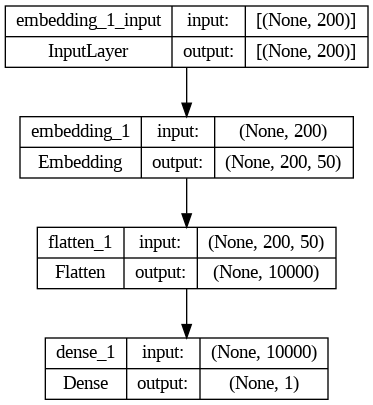

In [ ]:
# Visualize architecture
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# Load the word index from IMDb dataset
word_index = imdb.get_word_index()

# Reverse the word index to map integers back to words
reverse_word_index = {value: key for (key, value) in word_index.items()}

review_texts = decode_review(x_train[:10])
review_texts

,text,index
0,and you could just imagine being there robert ...,0
1,big big bad music and a these are the words to...,1
2,this has to be one of the worst films of the w...,2
3,the death of his parents br br he is to make a...,3
4,worst of my life br br i this movie up at for ...,4
5,begins better than it ends funny that the all ...,5
6,production and performances in this of classic...,6
7,or a really bad film that i am to say anything...,7
8,that the of something truly special and unique...,8
9,this movie has many problem with it that makes...,9


In [ ]:
# Get some most used words

review_texts['text_words'] = review_texts['text'].str.lower().str.split()
all_words = [word for words in review_texts['text_words'] for word in words]
word_freq = Counter(all_words)
most_common_words = word_freq.most_common()

print(most_common_words)

[('the', 87), ('and', 46), ('of', 45), ('a', 41), ('is', 32), ('i', 30), ('it', 30), ('that', 28), ('to', 28), ('this', 25), ('br', 22), ('was', 20), ('film', 19), ('in', 18), ('you', 14), ('with', 13), ('just', 11), ('for', 11), ('but', 11), ('have', 10), ('on', 10), ('an', 9), ('so', 9), ('at', 9), ('movie', 9), ('about', 9), ('all', 8), ('story', 8), ('like', 8), ('much', 7), ('they', 7), ('good', 7), ('are', 7), ('bad', 7), ('there', 6), ('worst', 6), ('ever', 6), ('one', 6), ('my', 6), ('not', 6), ('being', 5), ('as', 5), ('were', 5), ('what', 5), ('up', 5), ('be', 5), ('life', 5), ('how', 5), ("it's", 5), ('over', 5), ('has', 5), ('other', 5), ("there's", 5), ('amazing', 4), ('great', 4), ('watch', 4), ('say', 4), ('if', 4), ('because', 4), ('big', 4), ('whole', 4), ('music', 4), ('made', 4), ('their', 4), ('then', 4), ('friends', 4), ('we', 4), ('or', 4), ('get', 4), ('stories', 4), ('more', 4), ('some', 4), ('through', 4), ('which', 4), ('low', 4), ('me', 4), ('from', 3), ('rea

Sum of Explained Variances: 0.0657


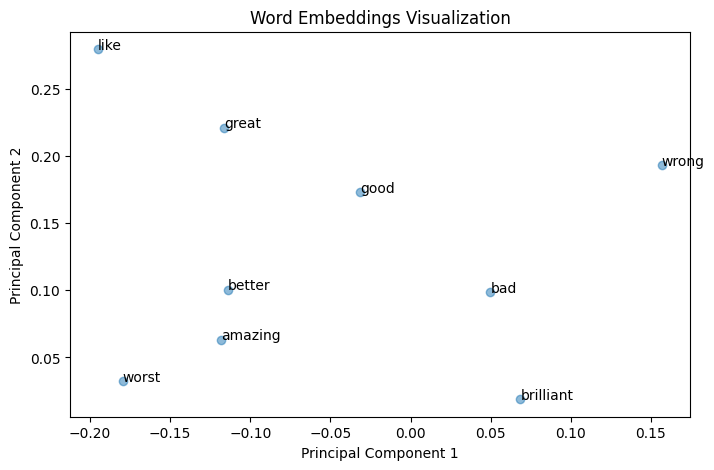

In [ ]:
# Get the weights of the Embedding layer
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

# Define a list of words you want to visualize
words_to_visualize = ['good', 'bad', 'like', 'worst', 'amazing', 'great', 'brilliant', 'wrong', 'better']

# Visualize the word embeddings
visualize_word_embeddings(weights, words_to_visualize)

## Pretrained models

Commonly, most training processes start from pre-trained models with a large dataset to adapt them to our particular problem. In this way we are able to save time and computational cost as well as to obtain good results.


- Explore to get pre-trained models: https://tfhub.dev/

- Embedding visualizations: https://projector.tensorflow.org/


### Word2vec

"*word2vec is not a singular algorithm, rather, it is a family of model architectures and optimizations that can be used to learn word embeddings from large datasets. Embeddings learned through word2vec have proven to be successful on a variety of downstream natural language processing tasks.*"

<br>

https://www.tensorflow.org/text/tutorials/word2vec

In [ ]:
# Load the Word2Vec embedding from Keras Hub
embedding_layer = hub.KerasLayer("https://tfhub.dev/google/Wiki-words-500/2",
                                 input_shape=[], dtype=tf.string)

In [ ]:
# 1. compare sentences with different meaning of bat
sentences = ["the bat ran away", "the bat is required to play baseball"]
words = tf.strings.split(sentences)
word_embeddings = tf.ragged.map_flat_values(embedding_layer, words)
compare_embeddings(sentences, word_embeddings, 'bat')

# 2. compare same meaning and different order within sentence
sentences = ["the bat ran away", "the bat is a nocturnal animal"]
words = tf.strings.split(sentences)
word_embeddings = tf.ragged.map_flat_values(embedding_layer, words)
compare_embeddings(sentences, word_embeddings, 'bat')

Embeddings are the same
Embeddings are the same


### ELMo

"*ELMo, is a type of deep contextualized word representation that models both (1) complex characteristics of word use (e.g., syntax and semantics), and (2) how these uses vary across linguistic contexts (i.e., to model polysemy)*"

<br>

https://paperswithcode.com/method/elmo

In [ ]:
# Load the Elmo embedding from Keras Hub
elmo = hub.load("https://tfhub.dev/google/elmo/2").signatures["default"]

In [ ]:
# 1. compare sentences with different meaning of bat
sentences = ["the bat ran away", "the bat is required to play baseball"]
word_embeddings = elmo(tf.constant(sentences))["elmo"]
compare_embeddings(sentences, word_embeddings, 'bat')

# 2. compare same meaning and different order within sentence
sentences = ["the bat ran away", "the bat is a nocturnal animal"]
word_embeddings = elmo(tf.constant(sentences))["elmo"]
compare_embeddings(sentences, word_embeddings, 'bat')

# 3. compare same sentence
sentences = ["the bat ran away", "the bat ran away"]
word_embeddings = elmo(tf.constant(sentences))["elmo"]
compare_embeddings(sentences, word_embeddings, 'bat')

Embeddings are different
Embeddings are different
Embeddings are the same


### Use hub embedding in a model

In [ ]:
# Dummy movie reviews and labels
reviews = [
    "This movie is fantastic and heartwarming.",
    "I hated this movie. It was awful.",
    "The acting in this film was amazing!",
    "The plot had so many holes; I couldn't enjoy it.",
]

labels = np.array([1, 0, 1, 0])

# Convert reviews to TensorFlow tensors of dtype=tf.string
reviews = tf.constant(reviews, dtype=tf.string)

In [ ]:
# Create a Sequential model
model = Sequential()

# Define the Word2Vec embedding layer (a lighter version 250d)
embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/Wiki-words-250/2",
    input_shape=[],
    dtype=tf.string,
    trainable=True,
)

# Add the embedding layer to the model
model.add(embedding_layer)

# Add a Flatten layer to convert the embedded text into a flat vector
model.add(Flatten())

# Add a Dense layer for classification
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(reviews, labels, epochs=10, batch_size=2)

Epoch 1/10
2/2 [==============================] - 2s 255ms/step - loss: 0.6489 - accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 0s 72ms/step - loss: 0.6509 - accuracy: 0.7500
Epoch 3/10
2/2 [==============================] - 0s 74ms/step - loss: 0.6212 - accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 0s 72ms/step - loss: 0.5958 - accuracy: 1.0000
Epoch 5/10
2/2 [==============================] - 0s 71ms/step - loss: 0.5693 - accuracy: 1.0000
Epoch 6/10
2/2 [==============================] - 0s 71ms/step - loss: 0.5298 - accuracy: 1.0000
Epoch 7/10
2/2 [==============================] - 0s 71ms/step - loss: 0.5447 - accuracy: 1.0000
Epoch 8/10
2/2 [==============================] - 0s 74ms/step - loss: 0.4867 - accuracy: 1.0000
Epoch 9/10
2/2 [==============================] - 0s 71ms/step - loss: 0.4514 - accuracy: 1.0000
Epoch 10/10
2/2 [==============================] - 0s 73ms/step - loss: 0.4629 - accuracy: 1.0000


In [ ]:
# Test some text
test_reviews = [
    "This movie is a masterpiece!",
    "I can't stand this film.",
]


mapper = {0: 'negative', 1: 'positive'}
test_reviews = tf.constant(test_reviews, dtype=tf.string)
predictions = model.predict(test_reviews)
predicted_labels = (predictions > 0.5).astype(int)

print()
for t, p in zip(test_reviews, predicted_labels):
  print(f"{t}: {mapper[int(p)]}")

1/1 [==============================] - 0s 26ms/step

b'This movie is a masterpiece!': positive
b"I can't stand this film.": negative
